In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from tensorflow.keras.utils import load_img, img_to_array 
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import glob

## Load and split data

In [2]:
def display_prev(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

def display_test(array1, array2, array3):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]
    images3 = array3[indices, :]

    

    plt.figure(figsize=(20, 4))
    for i, (image1, image2, image3) in enumerate(zip(images1, images2, images3)):
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(image1)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image2)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(image3)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.tight_layout()
    plt.show()

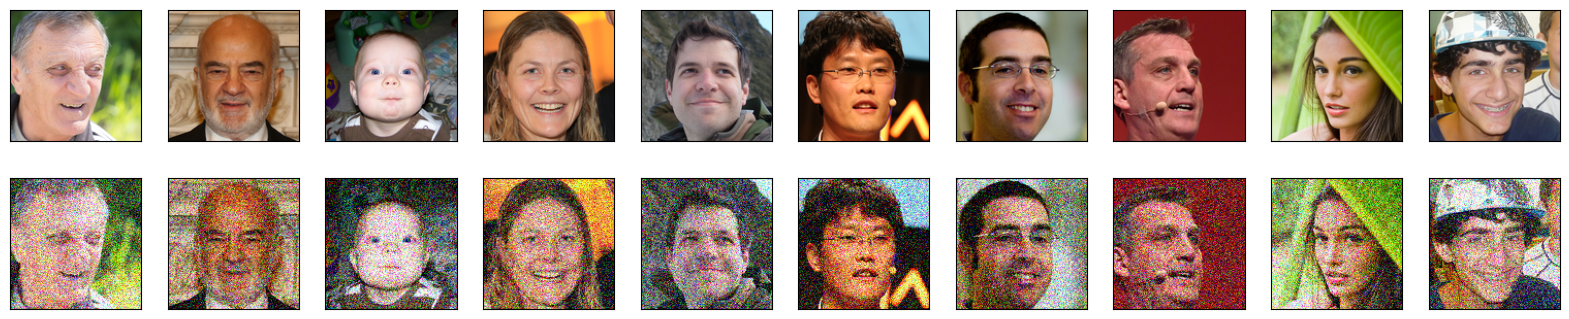

In [3]:
# load the test data
import pickle

with open('../DATA/thumbnails128x128/test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

with open('../DATA/thumbnails128x128/noisy_test_data.pkl', 'rb') as f:
    noisy_test_data = pickle.load(f)

display_prev(test_data, noisy_test_data)

## Predictions

### Prediction ResNet18

In [4]:
#load the model
model = keras.models.load_model('final_models/resnet18AE_color_lr0001.h5')

#predict the images
preds_r18 = model.predict(noisy_test_data)

63/63 [==============================] - 8s 40ms/step


### Prediction ResNet34

In [5]:
#load the model
model = keras.models.load_model('final_models/resnet34AE_color_lr0001.h5')

#predict the images
preds_r34 = model.predict(noisy_test_data)

63/63 [==============================] - 4s 49ms/step


### Prediction ResNet50

In [6]:
#load the model
model = keras.models.load_model('final_models/resnet50AE_color_lr0001.h5')

#predict the images
preds_r50 = model.predict(noisy_test_data)

63/63 [==============================] - 8s 96ms/step


### Prediction VGG16

In [7]:
#load the model
model = keras.models.load_model('final_models/vgg16AE_color_lr0001.h5')

#predict the images
preds_v16 = model.predict(noisy_test_data)

63/63 [==============================] - 10s 95ms/step


### Prediction VGG19

In [8]:
#load the model
model = keras.models.load_model('final_models/vgg19AE_color_lr0001.h5')

#predict the images
preds_v19 = model.predict(noisy_test_data)

63/63 [==============================] - 5s 71ms/step


## Metrics

In [9]:
# ssim from skimage
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(original, preds):
    ssim_val = []
    for i in range(original.shape[0]):
        ssim_val.append(ssim(original[i], preds[i], multichannel = True, data_range=1.0, channel_axis=2))
    return ssim_val

In [10]:
def get_metrics_eval(test_x_image, preds, model_name):
    ssim_val = calculate_ssim(test_x_image, preds)
    mse = tf.keras.losses.mean_squared_error(tf.convert_to_tensor(test_x_image), tf.convert_to_tensor(preds))
    mae = tf.keras.losses.mean_absolute_error(tf.convert_to_tensor(test_x_image), tf.convert_to_tensor(preds))
    psnr = tf.image.psnr(tf.convert_to_tensor(test_x_image), tf.convert_to_tensor(preds), 1.0)

    mean_ssim = np.mean(ssim_val)
    mean_mse = tf.reduce_mean(mse).numpy()
    mean_mae = tf.reduce_mean(mae).numpy()
    mean_psnr = tf.reduce_mean(psnr).numpy()

    std_ssim = np.std(ssim_val)
    std_mse = tf.math.reduce_std(mse).numpy()
    std_mae = tf.math.reduce_std(mae).numpy()
    std_psnr = tf.math.reduce_std(psnr).numpy()

    output = f"Model: {model_name}\t"
    output += f"SSIM: {mean_ssim:.4f}\u00B1{std_ssim:.4f}\t"
    output += f"MSE: {mean_mse:.4f}\u00B1{std_mse:.4f}\t"
    output += f"MAE: {mean_mae:.4f}\u00B1{std_mae:.4f}\t"
    output += f"PSNR: {mean_psnr:.4f}\u00B1{std_psnr:.4f}\n"
    # 4 decimals
    print(output)

In [11]:
get_metrics_eval(test_data, preds_r18, "ResNet18")
get_metrics_eval(test_data, preds_r34, "ResNet34")
get_metrics_eval(test_data, preds_r50, "ResNet50")
get_metrics_eval(test_data, preds_v16, "VGG16")
get_metrics_eval(test_data, preds_v19, "VGG19")

Model: ResNet18	SSIM: 0.7332±0.0524	MSE: 0.0040±0.0099	MAE: 0.0439±0.0395	PSNR: 24.2767±1.6370

Model: ResNet34	SSIM: 0.7386±0.0550	MSE: 0.0040±0.0103	MAE: 0.0432±0.0409	PSNR: 24.3055±1.7331

Model: ResNet50	SSIM: 0.7345±0.0556	MSE: 0.0042±0.0111	MAE: 0.0438±0.0420	PSNR: 24.1440±1.7596

Model: VGG16	SSIM: 0.6578±0.0716	MSE: 0.0059±0.0143	MAE: 0.0516±0.0498	PSNR: 22.7698±1.9604

Model: VGG19	SSIM: 0.6312±0.0771	MSE: 0.0066±0.0158	MAE: 0.0547±0.0528	PSNR: 22.2844±1.9565



In [12]:
def get_metric_image(original, predicted):
    ssim_value = ssim(original, predicted, multichannel = True, data_range=1.0, channel_axis=2)
    psnr = tf.image.psnr(tf.convert_to_tensor(original), tf.convert_to_tensor(predicted), 1.0).numpy()

    return round(ssim_value, 4), round(psnr,4)

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def display(indices, language='en'):
    rows = len(indices)
    columns = 7

    fig, axs = plt.subplots(rows, columns, figsize=(20, 15))
    
    for i, index in enumerate(indices):
        original = test_data[index]
        gray_scale = noisy_test_data[index]
        resnet18 = preds_r18[index]
        resnet34 = preds_r34[index]
        resnet50 = preds_r50[index]
        vgg16 = preds_v16[index]
        vgg19 = preds_v19[index]
        
        axs[i, 0].imshow(original)
        axs[i, 0].axis('off')
        # axs[i, 0].set_title('Original')

        axs[i, 1].imshow(gray_scale)
        axs[i, 1].axis('off')
        ssim_val, psnr_val = get_metric_image(original, gray_scale)
        axs[i, 1].text(0.5, -0.1, f"SSIM: {ssim_val:.4f}\nPSNR: {psnr_val:.4f}", 
                       fontsize=12, ha='center', va='top', transform=axs[i, 1].transAxes)

        axs[i, 2].imshow(np.clip(resnet18, 0, 1))
        axs[i, 2].axis('off')
        ssim_val, psnr_val = get_metric_image(original, resnet18)
        axs[i, 2].text(0.5, -0.1, f"SSIM: {ssim_val:.4f}\nPSNR: {psnr_val:.4f}", 
                       fontsize=12, ha='center', va='top', transform=axs[i, 2].transAxes)

        axs[i, 3].imshow(resnet34)
        axs[i, 3].axis('off')
        ssim_val, psnr_val = get_metric_image(original, resnet34)
        axs[i, 3].text(0.5, -0.1, f"SSIM: {ssim_val:.4f}\nPSNR: {psnr_val:.4f}", 
                       fontsize=12, ha='center', va='top', transform=axs[i, 3].transAxes)

        axs[i, 4].imshow(resnet50)
        axs[i, 4].axis('off')
        ssim_val, psnr_val = get_metric_image(original, resnet50)
        axs[i, 4].text(0.5, -0.1, f"SISM: {ssim_val:.4f}\nPSNR: {psnr_val:.4f}", 
                       fontsize=12, ha='center', va='top', transform=axs[i, 4].transAxes)
        
        axs[i, 5].imshow(vgg16)
        axs[i, 5].axis('off')
        ssim_val, psnr_val = get_metric_image(original, vgg16)
        axs[i, 5].text(0.5, -0.1, f"SISM: {ssim_val:.4f}\nPSNR: {psnr_val:.4f}", 
                       fontsize=12, ha='center', va='top', transform=axs[i, 5].transAxes)

        axs[i, 6].imshow(vgg19)
        axs[i, 6].axis('off')
        ssim_val, psnr_val = get_metric_image(original, vgg19)
        axs[i, 6].text(0.5, -0.1, f"SISM: {ssim_val:.4f}\nPSNR: {psnr_val:.4f}", 
                       fontsize=12, ha='center', va='top', transform=axs[i, 6].transAxes)


        
    # Añadir texto centrado debajo de cada columna
    if language == 'en':
        column_titles = [
            "Original",
            "Noisy \n(\u03C3=0.2)",
            "ResNet18",
            "ResNet34",
            "ResNet50",
            "VGG16",
            "VGG19"
        ]
    elif language == 'es':
        column_titles = [
            "Original",
            "Ruido \n(\u03C3=0.2)",
            "ResNet18",
            "ResNet34",
            "ResNet50",
            "VGG16",
            "VGG19"
        ]

    for col in range(columns):
        # Obtener la posición media de la columna en coordenadas normalizadas
        mid = axs[0, col].get_position().x0 + axs[0, col].get_position().width / 2
        fig.text(
            mid,      # posición x centrada para cada columna
            0.9,      # posición y ajustada fuera de las imágenes
            column_titles[col], 
            ha='center', va='center', fontsize=20
        )

    plt.subplots_adjust(hspace=0.4)
    plt.show()


In [14]:
# list of 5 random indices
indices = list(np.random.choice(test_data.shape[0], 5))
indices

[1794, 279, 1304, 223, 1175]

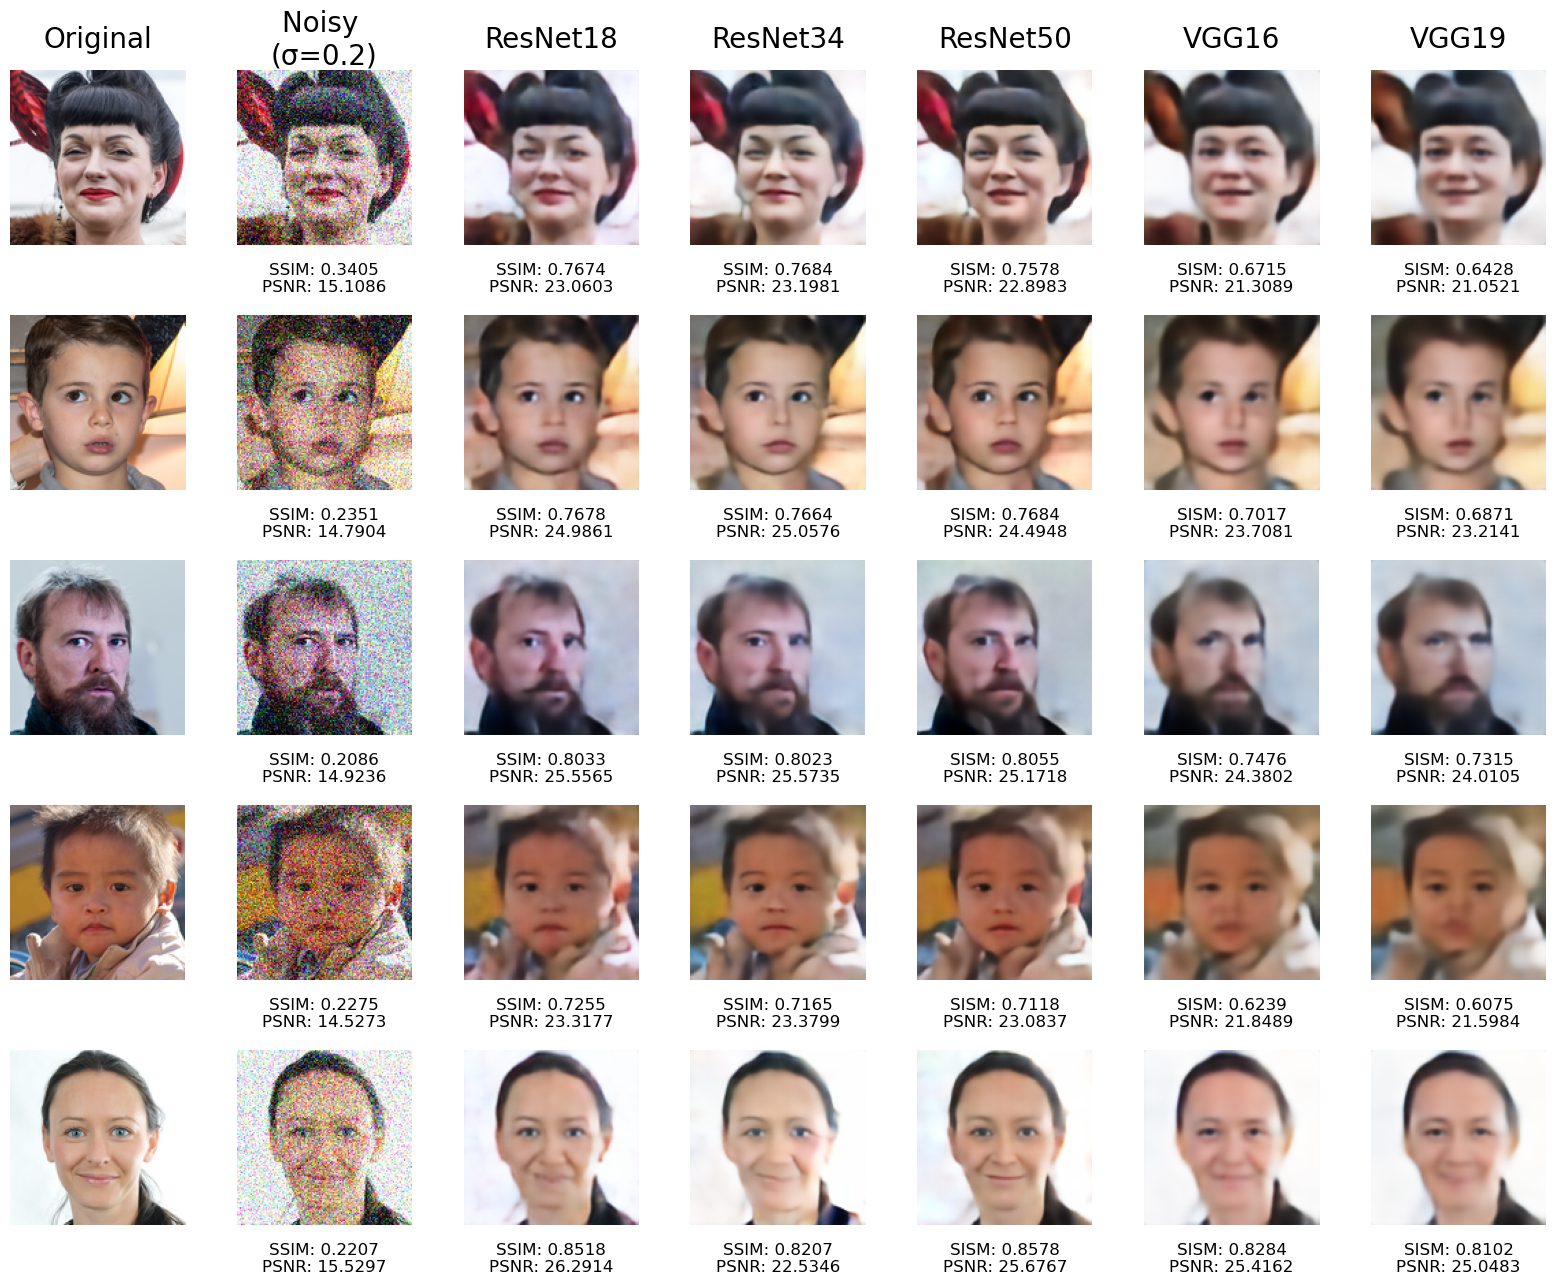

In [15]:
display(indices)

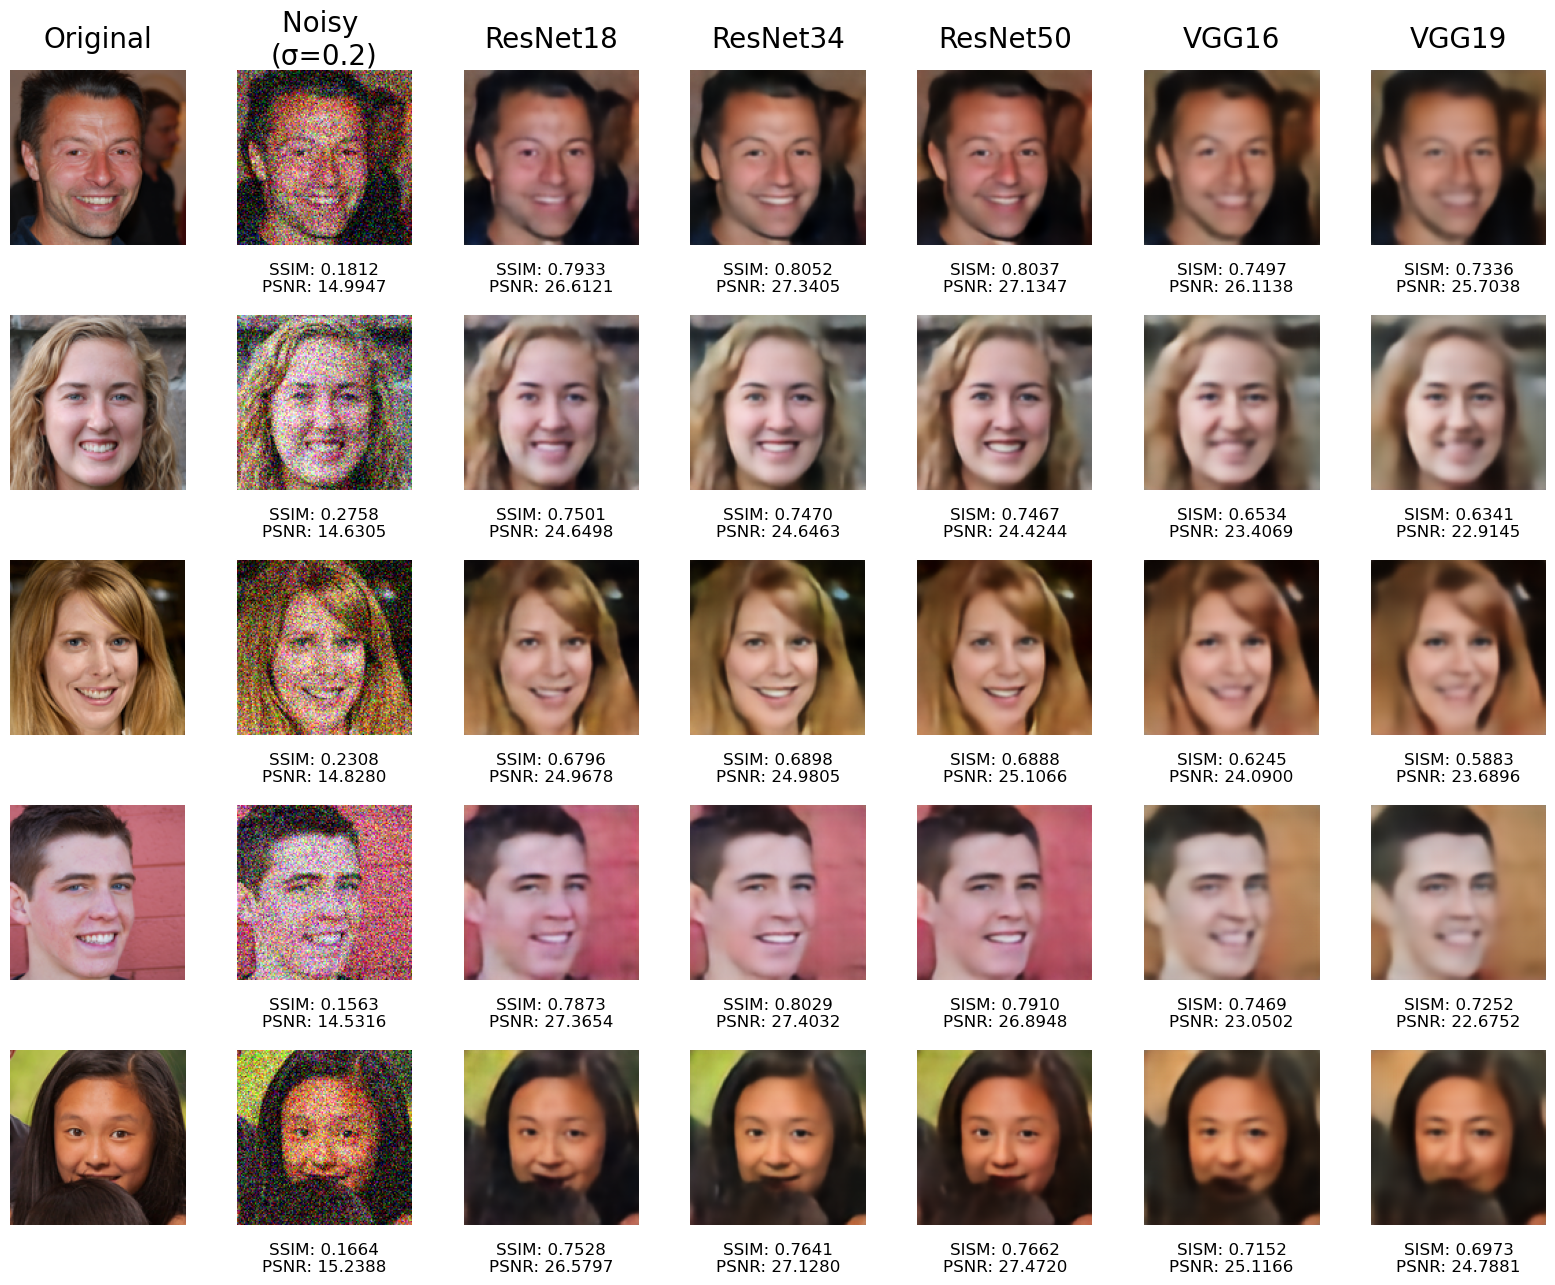

In [16]:
display([964,1388,919,1157,1261])

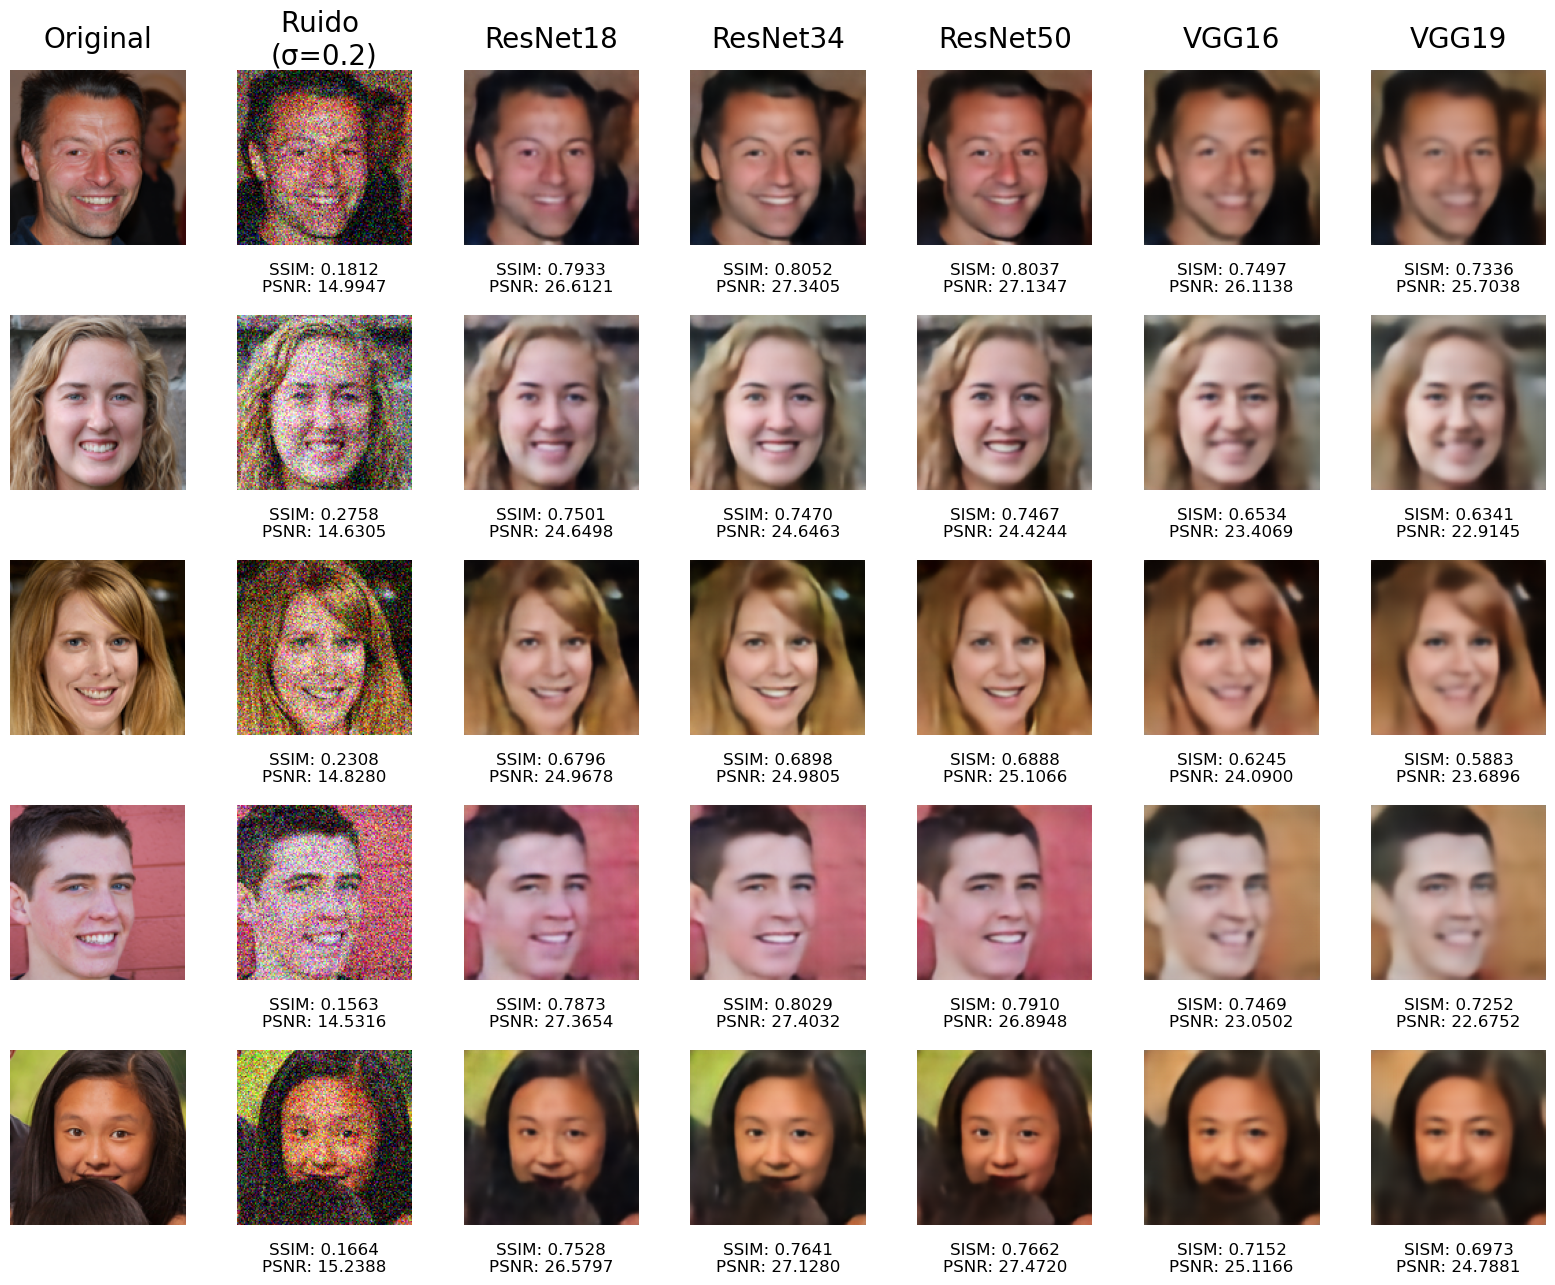

In [17]:
display([964,1388,919,1157,1261],"es")